[前回](http://hkwi.github.io/kobe-barcelona/app/2016/10/01/preschool.html)の結果で待機児童の状況は、年齢が上がるごとに地域的な状況は大きく違うことが見て取れた。

In [1]:
%matplotlib inline

In [2]:
import re
import glob
import pandas as pd
import geopandas as gpd
import scipy.spatial
import numpy
import math
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon

再び最新のデータを分析する。

In [3]:
nib = gpd.read_file("../data/hkwi/shinseido-2016-09.json")

#"状況,利用定員（２・３号）"は本園に合算されているので使わない
k1 = ["状況,合計", "１号,認可定員(全体)", "２号３号,利用定員（2・3号）"]
k2 = ["状況,申込児童数 %s歳児" % "０１２３４５"[i] for i in range(6)]
k3 = ["%d歳" % i for i in range(6)]
k4 = ["状況,入所の可能性 %s歳児" % i for i in "０１２３４５"]

# nib のセルのいくつかは数値に補足情報が付いているので、除去する
def drop_notes(c):
    if c is not None and len(c):
        m = re.match(r'^(\d+)\s*[（\()]内地域枠\d+[）\)]$', c)
        if m:
            return int(m.group(1))
        elif c[-1] in "*＊":
            return int(c[:-1])
        else:
            return int(c)
    return None

for k in k1+k2:
    nib[k] = nib[k].apply(drop_notes)

施設によって、受け入れている年齢がバラバラになっていることが、次の表から見て取れる。理由の一つはきっとこれだろう。地域や年齢によって状況が異なるであろうことが予測される。

In [4]:
r = pd.concat([nib, pd.Series([1]*len(nib.index), index=nib.index, name="数")], axis=1)
r1 = r.replace("〇","○").rename(columns=dict(zip(k4,k3)))
r1[k3+["状況,合計","数"]].groupby(k3).sum()

状況,合計    数
0歳 1歳 2歳 3歳 4歳 5歳             
                      NaN    1
         ×  ×  ×     24.0    4
               ○      0.0    1
            ○  ×      1.0    1
         ○  ×  ○      3.0    1
            ○  ×      0.0    1
               ○      1.0    2
      ×  ×  ×  ×     37.0    6
      ○  ○  ×  ○      0.0    1
   ×  ×               0.0    8
         ×  ×  ×     32.0    5
               ○     11.0    2
            ○  ×      5.0    2
               ○      3.0    1
         ○            1.0    1
            ○  ×      2.0    2
      ○               1.0    1
         ×  ○  ×      1.0    1
         ○  ○  ×      4.0    1
               ○      2.0    4
   ○  ○  ○  ○  ○      0.0    1
×                     5.0   17
   ×                  6.0    2
      ×              58.0   68
         ×            3.0    1
            ×  ×   1559.0  124
               ○    161.0   11
            ○  ×    141.0   16
               ○    141.0   20
         ○            0.0    1
            ×  ×     38.0    4
               ○     16.0    3
            ○  ×      3.0    1
               ○     56.0    9
      ○              13.0    5
         ×  ×  ×     46.0    6
               ○      5.0    1
            ○  ×      8.0    2
               ○     26.0    4
         ○  ×  ○      6.0    1
            ○  ×      3.0    1
               ○     10.0    5
   ○  ×  ×  ×  ×      7.0    1
         ○  ○  ○      6.0    2
      ○               3.0    3
         ×  ×  ○      3.0    1
         ○  ○  ○      4.0    1
○                     0.0    3
   ×  ×               1.0    1
         ×  ×  ×     71.0    7
         ○  ○  ○      1.0    1
      ○  ○  ○  ○      3.0    4
   ○  ○               2.0    3
         ×  ×  ×      1.0    1
         ○  ○  ○      7.0    3

## 地理分布

単位児童当たりの申込児童数の、地理分布を求める。区域については、施設の位置からボロノイ図で領域を分割し、国勢調査の領域との積をとって分析する。

同一住所に複数の施設が存在したりするので、まず位置情報だけで分割できるようにする。

In [5]:
coords_nib = [r.coords[0] for _,r in nib.geometry.iteritems()]
coords = []
for c in coords_nib:
    if c not in coords:
        coords.append(c)

pts = gpd.GeoDataFrame([{"geometry":Point(x,y)} for x,y in coords], crs="+init=epsg:4326")
nib_pti = pd.Series([coords.index(c) for c in coords_nib], index=nib.index)

e-Stat の区域データを読み込む。

In [6]:
us = [gpd.read_file(f) for f in glob.glob("../data/estat/h22ka281*.shp")]
pib_ = gpd.GeoDataFrame(pd.concat(us, ignore_index=True), crs=us[0].crs)
pib = pib_[(pib_["MOJI"]!="水面") & (pib_["MOJI"].isnull()==False)] # 海上を取り除く

be = [("minx",min), ("miny",min), ("maxx",max), ("maxy",max)]
pib_ext = [Point([be[j][1](pib.bounds[be[j][0]]) for j in i])
   for i in ((0,1),(2,1),(2,3),(0,3))]

神戸市の人口データを読み込む。

In [7]:
ages=["%d歳" % i for i in range(100)]+["100歳以上"]
def load_zensi(fname):
    e = pd.ExcelFile(fname)
    opts = dict(skiprows=1, converters={"区コード":str, "町コード":str})
    dfs = [e.parse(s, **opts).iloc[1:,:] for s in e.sheet_names if s != "神戸市"]
    return pd.DataFrame(pd.concat(dfs, ignore_index=True))

zib_ = load_zensi("../data/kobe/zensi2808.xls")
# 直接 KEYCODE1 が引けるなら、それを採用
zib = zib_.assign(KEYCODE1=lambda df:df["町コード"][df["町コード"].isin(set(pib["KEYCODE1"]))])
# 引けなければ、緯度経度から解決を試みる
qname = zib_.apply(lambda r:"神戸市 %s %s" % (r["区・支所"].replace("支所",""), r["町名"]), axis=1)
try:
    cache = pd.read_json(open("../cache/kobe.json", encoding="UTF-8")).T
except:
    cache = pd.DataFrame([], columns=["lat", "lng"])

qn = pd.DataFrame(qname, columns=["qname"])
qa = qn[zib["町コード"].isin(set(pib["KEYCODE1"]))==False].join(cache, on="qname", how="inner")
pt = gpd.GeoDataFrame(qa.apply(lambda r:Point(r["lng"], r["lat"]), axis=1), columns=["geometry"], crs="+init=epsg:4326")
pt_mv = gpd.tools.sjoin(pt, pib.to_crs("+init=epsg:4326"), op="within")
zib.loc[pt_mv.index, "KEYCODE1"] = pt_mv["KEYCODE1"]

ボロノイ図関連のルーチンを用意する。

In [8]:
def voronoi(npts):
    # Add extra points to create closed Polygon for all facilities
    ext = []
    for pt in pib_ext:
        dist = npts.distance(pt)
        n = npts[dist==min(dist)].geometry.iloc[0]
        ext.append(Point(pt.x*2 - n.x, pt.y*2 - n.y))

    npts_ext = gpd.GeoDataFrame([dict(geometry=p, dummy=1) for p in ext])
    g = gpd.GeoDataFrame(pd.concat([npts, npts_ext], ignore_index=True))
    v = scipy.spatial.Voronoi([p.coords[0] for i,p in g.geometry.iteritems()])
    return v

def voronoi2region(npts, v, **kwargs):
    vp = [dict(geometry=Polygon([v.vertices[vt] for vt in v.regions[r]]),
            npti=npts.index[i], **kwargs)
        for i,r in enumerate(v.point_region) if -1 not in v.regions[r]]
    vnu2 = gpd.GeoDataFrame(vp)
    assert vnu2.shape[0] == npts.shape[0]
    return vnu2

def voronoi_neighbors(npts, v):
    rp = v.ridge_points
    return {npts.index[i]:
        [npts.index[j] for j in list(rp[rp[:,0]==i][:,1]) + list(rp[rp[:,1]==i][:,0])
            if j < len(npts.index)]
        for i in range(len(v.points))
            if i < len(npts.index)}

def regions(npts, **kwargs):
    return voronoi2region(npts, voronoi(npts), **kwargs)

## 5歳児

手始めに 5 歳児の申込数を地図上に表現してみる。

In [9]:
nibi = nib["状況,申込児童数 ５歳児"].isnull()==False
nib2 = nib[nibi]
# CRS は面積の計算できる座標系に揃える。
pt2 = pts.to_crs(pib.crs).loc[set(nib_pti[nibi])]
v = voronoi(pt2)
r2 = voronoi2region(pt2, v)
pt2_neigh = voronoi_neighbors(pt2, v)

In [10]:
# この計算は重い！
ta = gpd.overlay(pib, r2, how="union")

In [11]:
tv = ta[ta["KEYCODE1"].isnull()==False]
tv.crs = pib.crs

tv_pop = pd.Series(0, index=tv.index, name="児童数")
k_pop = zib.fillna(0).groupby("KEYCODE1").sum()
for k in set(pib["KEYCODE1"]):
    if k not in k_pop.index:
        continue
    t = tv[tv["KEYCODE1"]==k]
    w = t.geometry.area / sum(t.geometry.area) * k_pop.loc[k, "5歳"]
    tv_pop[t.index] += w

5歳児の人数の合計値が正しいか検算する。

In [12]:
zib["5歳"].sum(), tv_pop.sum()

(12865.0, 12864.999999999987)

申込数を児童数に応じて配分する。

In [13]:
tv_wait = pd.Series(0, index=tv.index, name="申込数")
for ri,r in nib2[nib2["状況,申込児童数 ５歳児"]>0].iterrows():
    pti = nib_pti[ri]
    t = tv[tv["npti"].isin([pti]+pt2_neigh[pti])]
    x = tv_pop[t.index] / tv_pop[t.index].sum() * r["状況,申込児童数 ５歳児"]
    tv_wait[t.index] += x

申込児童数の合計値が正しいか検算する。

In [14]:
nib2["状況,申込児童数 ５歳児"].sum(), tv_wait.sum()

(50.0, 49.999999999999744)

地図上にプロットするとこのようになる。`bwr` カラーマップでは、赤が激戦区となる。

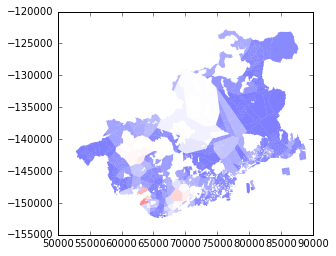

In [15]:
t = pd.concat([tv["geometry"], tv_pop, tv_wait/tv_pop], axis=1).rename(columns={0:"rate"})
g = gpd.GeoDataFrame(t[tv_pop!=0])
g.plot(column="rate", cmap="bwr", linewidth=0)